# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.greedy=True

import json
import os
import time
from collections import OrderedDict
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from PIL import Image

# workspace specific imports

from workspace_utils import active_session


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Data folders

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [3]:
# Data parameters

batch_size = 64
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]


In [4]:
# DONE: Define your transforms for the training, validation, and testing sets

data_transforms = {
    'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(45),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
                                 ]),
    'valid' : transforms.Compose([transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
                                 ]),
    'test'  : transforms.Compose([transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
                                 ])
}


# DONE: Load the datasets with ImageFolder

image_datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test'  : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}


# DONE: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size),
    'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size)
}


# Warn if missing data

if not dataloaders['train']:
    print(f"Warning : No training images found in {train_dir}")
    
if not dataloaders['valid']:
    print(f"Warning : No validation images found in {valid_dir}")
    
if not dataloaders['test']:
    print(f"Warning : No test images found in {test_dir}")    

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
# load map of image labels to flower names 

# (I moved the import to the top)

filename = 'cat_to_name.json'

with open(filename, 'r') as f:
    cat_to_name = json.load(f)

# warn if label names did not load

if not cat_to_name:
    print(f"Warning : No label dictionary created from file {filename}")
    

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [6]:
# DONE: Build and train your network

## HYPERPARAMETERS

In [7]:
# Architecture

# I wanted to extract these directly from torch model
# features but didn't come up with a reliable way so
# I hard coded the input_sizes for allowed models.
input_sizes  = {'alexnet':9216, 'vgg16':25088}

arch         = 'vgg16'
n_inputs     = input_sizes[arch]
n_outputs    = len(cat_to_name)
hidden_units = [2048,512]

# Hyperparameters

learn_rate   = 0.001
dropout      = 0.2
epochs       = 15
epoch        = 0
step         = 0
val_every    = 20
train_stats  = []
train_loss   = 0
val_loss_min = 0
save_accuracy = 0.7 # start saving best checkpoint at this accuracy

# Additional properties

n_images_train  = len(image_datasets['train'])
n_images_valid  = len(image_datasets['valid'])
n_images_test   = len(image_datasets['test'])
n_batches_train = len(dataloaders['train'])
n_batches_valid = len(dataloaders['valid'])
n_batches_test  = len(dataloaders['test'])

class_to_idx    = image_datasets['train'].class_to_idx
idx_to_class    = {int(v):int(k) for k,v in class_to_idx.items()}

# Display templates

layout_vh   = "{:^8} {:<6} {:>12} {:>12} {:>12} {:>10} {:>8}"
layout_vr   = "{:^3d}/{:<4d} {:<6d} {:>12.3f} {:>12.3f} {:>12.3f} {:>10} {:>8}"


In [8]:
# Determine compute device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")


Using cuda


## MODELS

In [9]:
def build_model_vgg():
    """ 
        Pretrained : VGG16
    """
    
    # load the pre-trained model
    model = models.vgg16(pretrained=True)

    # freeze pre-trained parameters
    for p in model.parameters():
        p.requires_grad = False

    # NOTE TO REVIEWER : initially I read in_features from the pre-trained
    # classifiers, however models varied, so I hardcoded n_inputs per model.
    
    n_inputs = 25088
    
    # define my classifier network
   
    # classifier input layer
    layers = list()
    layers.append( ('input', nn.Linear(n_inputs, hidden_units[0])) )
    layers.append( ('relu_0', nn.ReLU()) )
    layers.append( ('drop_0', nn.Dropout(dropout)) )

    # hidden layers
    for i in range(1, len(hidden_units)):
        layers.append( (f"layer{i}", nn.Linear(hidden_units[i-1], hidden_units[i])) )
        layers.append( (f"relu_{i}", nn.ReLU()) )
        layers.append( (f"drop_{i}", nn.Dropout(dropout)) )

    # output layer
    layers.append( ('layerz', nn.Linear(hidden_units[-1], n_outputs)) )
    layers.append( ('output', nn.LogSoftmax(dim=1)) )
    
    
    # create classifier
    model.classifier = nn.Sequential(OrderedDict(layers))

    # gradient descent optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)

    # error loss function
    criterion = nn.NLLLoss()

    # move model to compute device
    model.to(device)

    return model,optimizer,criterion

In [10]:
def build_model_alexnet():
    """ 
        Pretrained : AlexNet
    """
    
    # load the pre-trained model
    model = models.alexnet(pretrained=True)

    # freeze pre-trained parameters
    for p in model.parameters():
        p.requires_grad = False
        
    # NOTE TO REVIEWER : initially I read in_features from the pre-trained
    # classifiers, however structures vary, so I hardcoded n_inputs
    
    n_inputs = 9216
    
    # define my classifier network
   
    # classifier input layer
    layers = list()
    layers.append( ('input', nn.Linear(n_inputs, hidden_units[0])) )
    layers.append( ('relu_0', nn.ReLU()) )
    layers.append( ('drop_0', nn.Dropout(dropout)) )

    # hidden layers
    for i in range(1, len(hidden_units)):
        layers.append( (f"layer{i}", nn.Linear(hidden_units[i-1], hidden_units[i])) )
        layers.append( (f"relu_{i}", nn.ReLU()) )
        layers.append( (f"drop_{i}", nn.Dropout(dropout)) )

    # output layer
    layers.append( ('layerz', nn.Linear(hidden_units[-1], n_outputs)) )
    layers.append( ('output', nn.LogSoftmax(dim=1)) )
    
    
    # create classifier
    model.classifier = nn.Sequential(OrderedDict(layers))

    # gradient descent optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)

    # error loss function
    criterion = nn.NLLLoss()

    # move model to compute device
    model.to(device)

    return model,optimizer,criterion

## SELECT MODEL

In [11]:
if arch=='alexnet':
    model,optimizer,criterion = build_model_alexnet()

In [12]:
if arch=='vgg16':
    model,optimizer,criterion = build_model_vgg()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 87412521.98it/s] 


In [13]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d


## TRAINING


In [19]:
# BEGIN TRAINING

# keep session active

with active_session():
    
    # begin training

    start_date = datetime.now().strftime("%d-%m-%Y %H:%M:%S UTC")
    start_time = time.time()

    print(f"Started training  : {start_date}")
    print(f"Model             : {arch}")
    print(f"Learn rate        : {learn_rate}")
    print(f"Training images   : {n_images_train}")
    print(f"Validation images : {n_images_valid}")
    print(f"Testing images    : {n_images_test}")
    print(f"Outputs           : {n_outputs}")
    print()
    print(f"Save above accuracy : {save_accuracy}")
    print()
    print(layout_vh.format('Epoch','Step','Train loss','Val loss','Accuracy','Elapsed','Saved'))

    # iterate through epochs

    while epoch < epochs:
        
        # epoch counter
        epoch += 1

        # iterate batches
        
        for images,labels in dataloaders['train']:

            # batch counter
            step += 1

            # move data to device
            images,labels = images.to(device), labels.to(device)

            # zero the gradients
            optimizer.zero_grad()

            # feed forward
            logps = model(images)

            # compute error
            loss = criterion(logps, labels)

            # backpropagate
            loss.backward()

            # gradient descent takes a step
            optimizer.step()

            # track total error
            train_loss += loss.item()


            # validate and output progress every N steps
            # this is split off into its own function in Part 2
            
            if step % val_every == 0:

                val_loss = 0
                accuracy = 0

                # evaluation mode, dropout and gradients off
                
                model.eval()
                
                with torch.no_grad():

                    # run model on validation data

                    for images,labels in dataloaders['valid']:

                        # move data to compute device
                        images,labels = images.to(device), labels.to(device)

                        # feed forward
                        logps = model(images)
                        loss = criterion(logps,labels)
                        val_loss += loss.item()

                        # calculate accuracy

                        # turn logarithmic probabilities back into probabilities
                        ps = torch.exp(logps)

                        # most likely prediction
                        top_ps,top_class = ps.topk(1, dim=1)

                        # determine accuracy to label
                        equality = top_class == labels.view(*top_class.shape)

                        # compute accuracy metric
                        accuracy += torch.mean(equality.type(torch.FloatTensor))

                
                # output stats so far
                
                train_loss /= val_every
                val_loss /= n_batches_valid
                accuracy /= n_batches_valid

                # initialize minimum validation loss
                
                val_loss_min = val_loss_min or val_loss

                # if best result so far save checkpoint
                
                saved=''
                
                if val_loss < val_loss_min and accuracy >= save_accuracy:
                    
                    val_loss_min = val_loss
                    if "save_checkpoint" in dir(): # in case the cell below hasn't run yet
                        save_checkpoint('models/checkpoint_'+arch+'.pth', silent=True)
                        saved='Y'
                    
                # update elapsed time
                elapsed_time = time.time() - start_time
                                
                # update + output training stats
                train_stats.append([epoch, step, train_loss, val_loss, float(accuracy), elapsed_time])

                print(layout_vr.format(epoch, epochs, step, train_loss, val_loss, 
                                       float(accuracy), 
                                       time.strftime('%H:%M:%S',time.gmtime(elapsed_time)),
                                       saved))
                
                # reset training loss
                train_loss = 0

                # switch model to training mode
                model.train()

    # display finished notification
    
    finish_date = datetime.now().strftime("%d-%m-%Y %H:%M:%S UTC")

    print(f"Training complete : {finish_date}")
    

Started training  : 21-12-2019 16:48:35 UTC
Model             : vgg16
Learn rate        : 0.001
Training images   : 6552
Validation images : 818
Testing images    : 819
Outputs           : 102

Save above accuracy : 0.7

 Epoch   Step     Train loss     Val loss     Accuracy    Elapsed    Saved
 1 /15   20            4.646        3.953        0.176   00:00:46         
 1 /15   40            3.878        3.091        0.318   00:01:30         
 1 /15   60            3.144        2.436        0.389   00:02:14         
 1 /15   80            2.632        2.059        0.464   00:02:58         
 1 /15   100           2.383        1.598        0.546   00:03:42         
 2 /15   120           2.141        1.587        0.547   00:04:24         
 2 /15   140           1.978        1.266        0.632   00:05:05         
 2 /15   160           1.883        1.166        0.671   00:05:47         
 2 /15   180           1.850        1.040        0.719   00:06:29        Y
 2 /15   200           1.755 

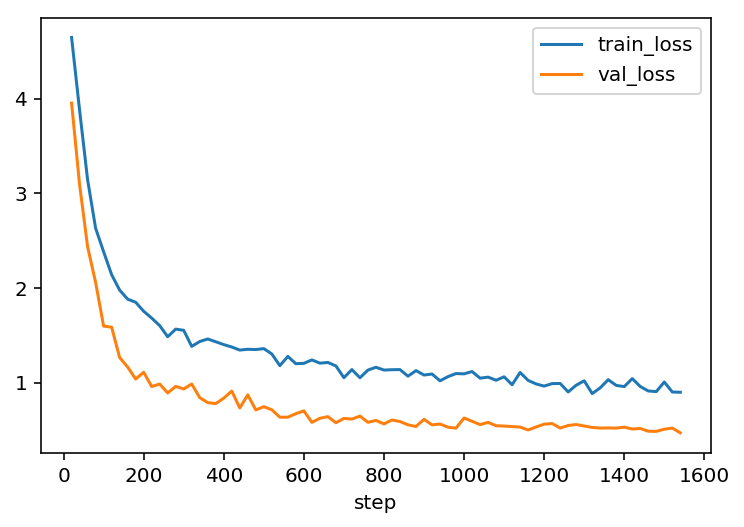

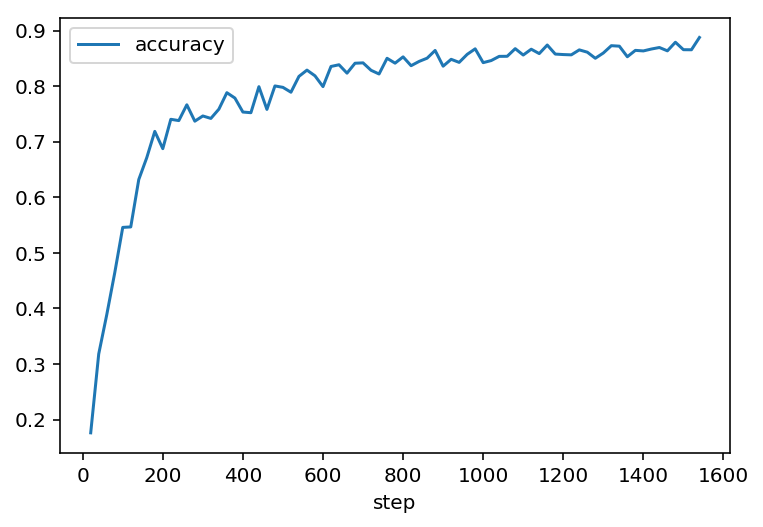

In [20]:
# show the training performance

graph = pd.DataFrame(train_stats, columns=['epoch','step','train_loss','val_loss','accuracy','elapsed'])
graph.plot.line(x='step',y=['train_loss','val_loss']);
graph.plot.line(x='step',y='accuracy');


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [21]:
# OPTIONAL : Load best checkpoint produced above if available

if "load_checkpoint" in dir():
    load_checkpoint('models/checkpoint_'+arch+'.pth')

In [22]:
# DONE: Do validation on the test set

# display templates
layout_tr   = "Model     : {}\nTest loss : {:<6.3f}\nAccuracy  : {:<6.3f}"

# track accuracy
test_loss = 0
accuracy = 0

# evaluation mode, dropout and gradients off

model.eval()

with torch.no_grad():

    # run model on validation data

    for images,labels in dataloaders['test']:

        # move data to compute device
        images,labels = images.to(device), labels.to(device)

        # run model
        logps = model(images)
        loss = criterion(logps,labels)
        test_loss += loss.item()

        # calculate accuracy

        # turn logarithmic outputs back into probabilities
        ps = torch.exp(logps)

        # most likely prediction
        top_ps,top_class = ps.topk(1, dim=1)

        # determine accuracy to label
        equality = top_class==labels.view(*top_class.shape)

        # compute accuracy
        accuracy += torch.mean(equality.type(torch.FloatTensor))

    # output test results
    print(layout_tr.format(arch, test_loss/n_batches_test, accuracy/n_batches_test))

# switch back to training mode
model.train();


Model     : vgg16
Test loss : 0.552 
Accuracy  : 0.842 


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
# DONE: Save the checkpoint 

def save_checkpoint(filepath='checkpoint.pth', include_optimizer=False, silent=False):
    
    checkpoint = {
            'arch'           : arch,
            'n_inputs'       : n_inputs,
            'n_outputs'      : n_outputs,
            'hidden_units'   : hidden_units,
            'epochs'         : epochs,
            'epoch'          : epoch,
            'step'           : step,
            'learn_rate'     : learn_rate,
            'dropout'        : dropout,
            'train_loss'     : train_loss,
            'val_loss'       : val_loss_min,
            'class_to_idx'   : image_datasets['train'].class_to_idx,
            'state_dict'     : model.state_dict()
        
    }
    
    # optional due to size
    if include_optimizer:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    
    torch.save(checkpoint, filepath)
    
    if not silent and os.path.exists(filepath):
        print(f"Saved model to {filepath} size {os.path.getsize(filepath)}")
    

In [15]:

save_checkpoint('models/checkpoint_'+arch+'.pth')


Saved model to models/checkpoint_vgg16.pth size 268800879


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# DONE: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    # retrieve parameters
    
    arch         = checkpoint['arch']
    n_inputs     = checkpoint['n_inputs']
    n_outputs    = checkpoint['n_outputs']
    hidden_units = checkpoint['hidden_units']
    epochs       = checkpoint['epochs']
    epoch        = checkpoint['epoch']
    step         = checkpoint['step']
    learn_rate   = checkpoint['learn_rate']
    dropout      = checkpoint['dropout']
    train_loss   = checkpoint['train_loss']
    val_loss_min = checkpoint['val_loss']

    # build appropriate model
    
    if arch=='alexnet':
        model,optimizer,criterion = build_model_alexnet()

    if arch=='vgg16':
        model,optimizer,criterion = build_model_vgg()

        
    # retrieve class-to-index
    
    class_to_idx = checkpoint['class_to_idx']
    idx_to_class = {int(v):int(k) for k,v in class_to_idx.items()}

    # now the state_dicts can be restored
    
    model.load_state_dict(checkpoint['state_dict'])
    
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    
    return model,optimizer,criterion


In [17]:
# loading checkpoint with training state for resume

model,optimizer,criterion = load_checkpoint('models/checkpoint_'+arch+'.pth')


In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # DONE : Process a PIL image for use in a PyTorch model

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]    
    
    process = transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean, std) 
    ])
    
    npimage = process(image).numpy()
    
    # transpose color channel
    
    #npimage = npimage.transpose(2,0,1)
    
    return npimage
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
def imshow(image, ax=None, title=None):
    
    if ax is None:
        fig, ax = plt.subplots()

    if title:
        ax.set_title(title)
        
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## TESTING IMAGE PROCESSING

In [25]:
image = process_image(Image.open('uploads/test.jpg'))

print(image.shape)


(3, 224, 224)


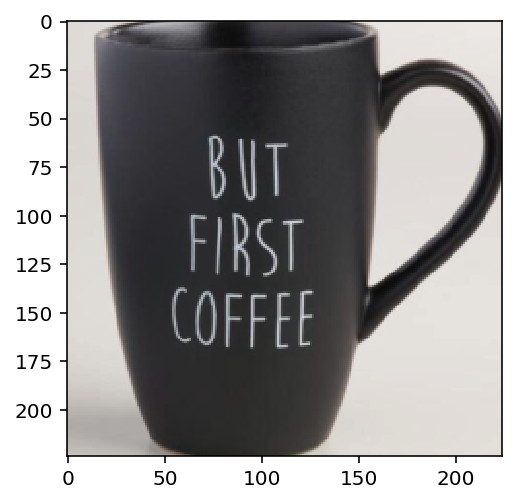

In [26]:
imshow(image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [27]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # DONE : Implement the code to predict the class from an image file
    
    # load the file using PIL
    image = Image.open(image_path)

    # input data pre-processing
    image_data = process_image(image)
    
    # convert to torch tensor
    image_tensor = torch.from_numpy(image_data).float()

    # move to compute device
    image_tensor = image_tensor.to(device)
    
    # make sure in inference mode
    model.eval()
    
    # feed forward
    output = model(image_tensor.view(1,3,224,224))

    # output probabilities
    ps = torch.exp(output)

    # top k probabilities
    top_ps,top_class = ps.topk(topk, dim=1)

    # return results as python lists
    probs = top_ps.cpu().detach().tolist()[0]
    classes = top_class.cpu().detach().tolist()[0]

    return probs,classes

## TEST IMAGE


Probabilities
 [0.9999980330467224, 1.7683369151200168e-06, 5.485886234168902e-08, 2.8309191435482717e-08, 1.349704903397253e-09]

Indices
 [52, 46, 38, 47, 71]

Class  Name                      Confidence
   54  Sunflower                    99.9998
   49  Oxeye Daisy                   0.0002
   41  Barbeton Daisy                0.0000
    5  English Marigold              0.0000
   71  Gazania                       0.0000


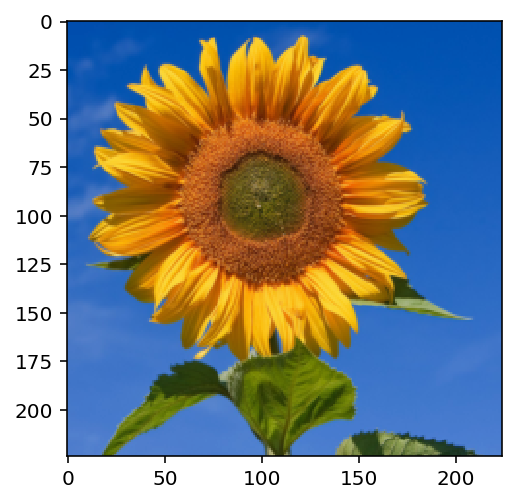

In [28]:
# checking that it works on a test dataset image

#filename = 'uploads/daffodil.jpg'
#filename = 'uploads/dandelion.jpg'
filename = 'uploads/sunflower.jpg'
#filename = 'uploads/20.jpg'
#filename = 'uploads/28.jpg'

# index-to-class
idx_to_class = {int(v):int(k) for k,v in image_datasets['train'].class_to_idx.items()}


# get prediction
probs,classes = predict(filename, model, 5)

# display raw results
print("\nProbabilities\n",probs)
print("\nIndices\n",classes)

# display the image
image = process_image(Image.open(filename))
imshow(image)

# display the confidence

print("\n{:>5}  {:<25} {:>10}".format('Class','Name','Confidence'))

for i in range(len(classes)):
    
    # retrieve the class and output label
    i_idx   = classes[i]
    i_class = idx_to_class[i_idx] # dict gets inverted in load_checkpoint
    i_name  = cat_to_name[str(i_class)].title()
    print(f"{i_class:>5d}  {i_name:<25} {probs[i]*100:10.4f}")



## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

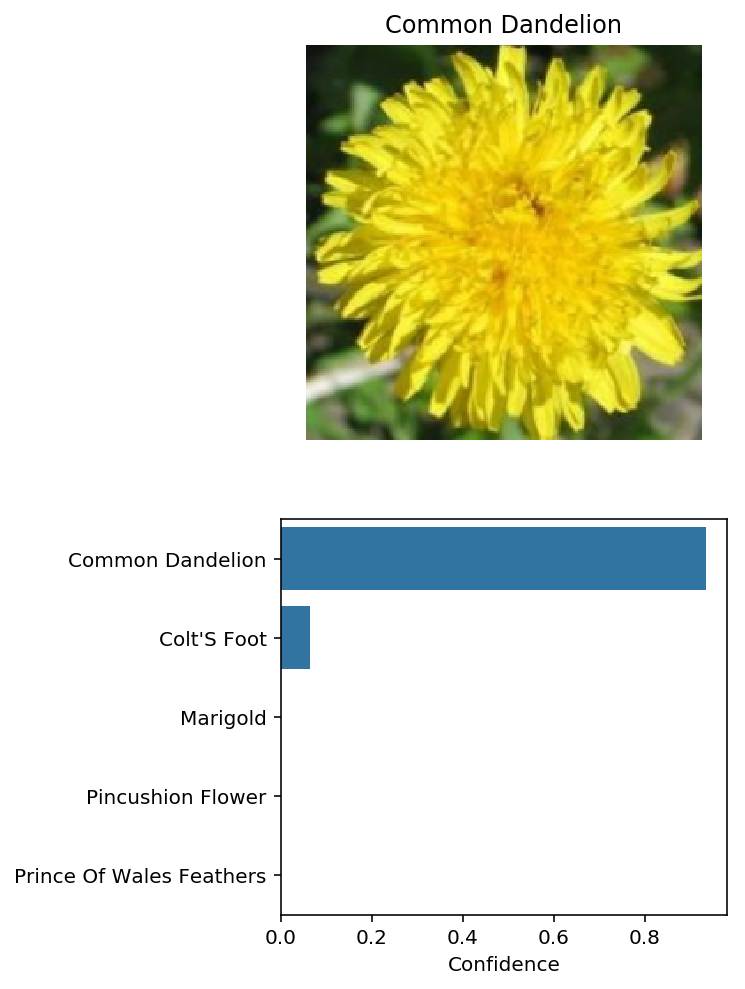

In [29]:
# DONE : Display an image along with the top 5 classes

# source image
#filename = 'uploads/daffodil.jpg'
filename = 'uploads/dandelion.jpg'
#filename = 'uploads/sunflower.jpg'
#filename = 'uploads/20.jpg'
#filename = 'uploads/28.jpg'

# get inference
probs,classes = predict(filename, model, 5);

# get friendly names of inference
names = [ cat_to_name[ str(idx_to_class[classes[i]]) ].title() for i in range(len(classes)) ];

# create dataframe for graphing
output = pd.DataFrame(list(zip(names,probs)), columns=['names','confidence'])

# create stacked figure
fig,ax = plt.subplots(2, 1, figsize=(4, 8));

# show image
image = process_image(Image.open(filename))
imshow(image, ax[0], names[0]);
ax[0].axis('off');

# show confidence graph
color = sb.color_palette()[0]
sb.barplot(data=output, x='confidence', y='names', color=color, orient='h');
plt.xlabel("Confidence");
plt.ylabel("");
plt.show()
